In [4]:
import os

os.environ["OMP_NUM_THREADS"] = "16"
os.environ["OPENBLAS_NUM_THREADS"] = "16"
os.environ["MKL_NUM_THREADS"] = "16"
os.environ["NUMEXPR_NUM_THREADS"] = "16"
os.environ["VECLIB_MAXIMUM_THREADS"] = "16"


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import random
import datetime

from astropy.table import Table

from itertools import combinations

from xgboost import XGBRegressor
from xgboost import plot_importance

from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from metrics import redshift_error

# from plotting_functions import plotTrainHistory, true_vs_pred_plot

In [1]:
tf.config.threading.set_intra_op_parallelism_threads(16)
tf.config.threading.set_inter_op_parallelism_threads(16)

NameError: name 'tf' is not defined

In [3]:
%load_ext tensorboard

In [5]:
filePath = "KiDS-DR5-WCScut_x_DESI-DR1-small.fits"
magnitudes = ['MAG_GAAP_u','MAG_GAAP_g', 'MAG_GAAP_r','MAG_GAAP_i1', 'MAG_GAAP_i2',
              'MAG_GAAP_Z', 'MAG_GAAP_Y','MAG_GAAP_J', 'MAG_GAAP_H','MAG_GAAP_Ks']

colors = ['u-g', 'u-r', 'u-i1', 'u-i2', 'u-Z', 'u-Y','u-J', 'u-H', 'u-Ks', 'g-r', 'g-i1', 'g-i2',
          'g-Z', 'g-Y', 'g-J', 'g-H','g-Ks', 'r-i1', 'r-i2', 'r-Z', 'r-Y', 'r-J', 'r-H', 'r-Ks', 
          'i1-i2','i1-Z', 'i1-Y', 'i1-J', 'i1-H', 'i1-Ks', 'i2-Z', 'i2-Y', 'i2-J', 'i2-H','i2-Ks', 
          'Z-Y', 'Z-J', 'Z-H', 'Z-Ks', 'Y-J', 'Y-H', 'Y-Ks', 'J-H','J-Ks', 'H-Ks']

df_default = Table.read(filePath, format='fits').to_pandas()

df = df_default.copy(deep=True)

pairs = list(combinations(magnitudes, 2))
for pair in pairs:
    mag1 = pair[0]
    mag2 = pair[1]
    
    df[f"{mag1.split('_')[-1]}-{mag2.split('_')[-1]}"] = df[mag1] - df[mag2]

quasar = df["SPECTYPE"][0]
galaxy = df["SPECTYPE"][2]
star = df["SPECTYPE"][3]

In [10]:
df_default.head(10)

,ID,RAJ2000,DECJ2000,MAG_GAAP_u,MAGERR_GAAP_u,MAG_GAAP_g,MAGERR_GAAP_g,MAG_GAAP_r,MAGERR_GAAP_r,MAG_GAAP_i1,...,MAG_GAAP_H,MAGERR_GAAP_H,MAG_GAAP_Ks,MAGERR_GAAP_Ks,MASK,Z,ZERR,ZWARN,SPECTYPE,SUBTYPE
0,b'KiDSDR5 J083706.078+000000.11 ',129.275328,0.000031,20.071587,0.010908,20.030886,0.004359,20.716307,0.009988,19.953472,...,20.200041,0.033646,20.109331,0.041916,0,1.756564,0.000261,0,b'QSO ',b'HIZ '
1,b'KiDSDR5 J083756.584+000000.23 ',129.485767,0.000066,23.471176,0.237037,22.261936,0.035937,21.481810,0.021359,20.796877,...,19.311653,0.013936,18.908943,0.014110,8,0.709194,0.000223,0,b'QSO ',b'LOZ '
2,b'KiDSDR5 J083425.528+000002.21 ',128.606368,0.000616,99.000000,1.641267,23.785587,0.165958,22.665600,0.059048,21.769638,...,19.817320,0.024350,19.443457,0.026196,65,0.862850,0.000154,0,b'GALAXY',NaN
3,b'KiDSDR5 J083554.878+000001.11 ',128.978659,0.000311,22.868792,0.163624,20.338383,0.006099,19.012503,0.002129,18.491550,...,17.713032,0.003405,17.989992,0.006235,0,0.000060,0.000006,0,b'STAR ',b'K '
4,b'KiDSDR5 J083457.996+000004.19 ',128.741652,0.001166,24.488472,0.770079,23.819162,0.168246,22.265823,0.048881,21.349340,...,20.366919,0.034742,20.444654,0.057492,0,0.000239,0.000038,0,b'STAR ',b'K '
5,b'KiDSDR5 J083651.099+000007.59 ',129.212914,0.002110,99.000000,0.943971,24.806629,0.325547,23.571363,0.131978,22.259520,...,20.333229,0.031516,19.981659,0.032670,0,0.972731,0.000200,0,b'GALAXY',NaN
6,b'KiDSDR5 J083508.705+000008.18 ',128.786271,0.002273,23.708508,0.259304,23.743654,0.123747,23.504795,0.124685,23.054132,...,22.817541,0.324954,22.093039,0.254430,3,0.958997,0.000038,0,b'GALAXY',NaN
7,b'KiDSDR5 J083439.213+000008.53 ',128.663389,0.002372,22.897318,0.130597,22.610897,0.042475,22.542023,0.050492,22.624901,...,21.909967,0.155908,21.942720,0.243249,0,1.380371,0.000068,0,b'GALAXY',NaN
8,b'KiDSDR5 J083421.331+000007.76 ',128.588882,0.002158,23.086843,0.149802,20.352772,0.005761,19.064672,0.002700,18.370880,...,17.513161,0.003068,17.722116,0.005646,65,0.000342,0.000003,0,b'STAR ',b'K '
9,b'KiDSDR5 J083600.044+000010.19 ',129.000184,0.002832,23.391870,0.329227,21.699673,0.026774,20.523722,0.011268,20.158506,...,18.900757,0.011209,18.630577,0.012264,0,0.433738,0.000011,0,b'GALAXY',NaN


In [ ]:
df_default.replace([99.0,-99.0], np.nan)
df_default.mean()

In [28]:
# basic regressor for quasars
df_qso = df[df["SPECTYPE"] == quasar]
X = df_qso[magnitudes + colors]
y = df_qso["Z"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model_qso = XGBRegressor(n_jobs=16, n_estimators=10000)
model_qso.fit(X_train,y_train)
y_pred = model_qso.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mean_redshift_err, redshift_err_std = redshift_error(y_test, y_pred)
print(f"MSE: {mse:.2f}")
print(f"R^2: {r2*100:.0f}%")
print(f"Redshift error: {mean_redshift_err:.2f} +/- {redshift_err_std:.2f}")
# true_vs_pred_plot(y_test, y_pred)

KeyboardInterrupt: 

In [32]:
# basic ann for quasars
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

normalizer = tf.keras.layers.Normalization()
normalizer.adapt(X_train.values)

model = tf.keras.models.Sequential(layers = [normalizer,
                                             tf.keras.layers.Dense(256, activation="relu"),
                                             tf.keras.layers.Dense(256, activation="relu"),
                                             tf.keras.layers.Dense(256, activation="relu"),
                                             tf.keras.layers.Dense(1)])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1E-4), loss='mse')

early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min',
                                                           patience=10, verbose=1, start_from_epoch=1)
callbacks = [early_stop_callback]

history = model.fit(X_train, y_train,
                    epochs=200,
                    verbose=0,
                    batch_size=64,
                    callbacks = callbacks,
                    validation_data =(X_val, y_val)
                   )

plotTrainHistory(history)

KeyboardInterrupt: 

In [6]:
y_pred = model.predict(X_test).reshape(-1)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mean_redshift_err, redshift_err_std = redshift_error(y_test, y_pred)
print(f"MSE: {mse:.2f}")
print(f"R^2: {r2*100:.0f}%")
print(f"Redshift error: {mean_redshift_err:.2f} +/- {redshift_err_std:.2f}")
true_vs_pred_plot(y_test, y_pred)

NameError: name 'model' is not defined

2025-07-03 09:22:46.499483: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_INVALID_DEVICE: invalid device ordinal
2025-07-03 09:22:46.499508: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:178] verbose logging is disabled. Rerun with verbose logging (usually --v=1 or --vmodule=cuda_diagnostics=1) to get more diagnostic output from this module
2025-07-03 09:22:46.499512: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:183] retrieving CUDA diagnostic information for host: borsuk
2025-07-03 09:22:46.499513: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:190] hostname: borsuk
2025-07-03 09:22:46.499609: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:197] libcuda reported version is: 570.133.7
2025-07-03 09:22:46.499630: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:201] kernel reported version is: 5

Epoch 47: early stopping
Restoring model weights from the end of the best epoch: 32.
CPU times: user 4min 13s, sys: 11.7 s, total: 4min 24s
Wall time: 1min 40s


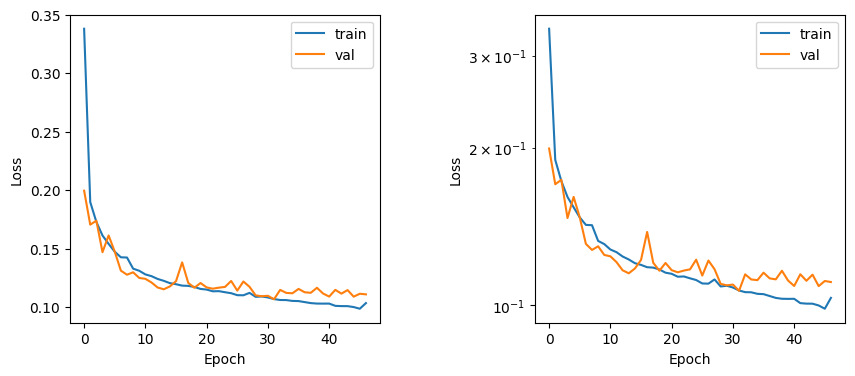

In [8]:
%%time
# ann for quasars
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

normalizer = tf.keras.layers.Normalization()
normalizer.adapt(X_train.values)

model = tf.keras.models.Sequential(layers = [normalizer,
                                             tf.keras.layers.Dense(256, kernel_initializer='normal', activation="relu"),
                                             tf.keras.layers.Dense(256, kernel_initializer='normal', activation="relu"),
                                             tf.keras.layers.Dense(256, kernel_initializer='normal', activation="relu"),
                                             tf.keras.layers.Dense(256, kernel_initializer='normal', activation="relu"),
                                             tf.keras.layers.Dense(256, kernel_initializer='normal', activation="relu"),
                                             tf.keras.layers.Dense(256, kernel_initializer='normal', activation="relu"),
                                             tf.keras.layers.Dense(256, kernel_initializer='normal', activation="relu"),
                                             tf.keras.layers.Dense(256, kernel_initializer='normal', activation="relu"),
                                             tf.keras.layers.Dense(256, kernel_initializer='normal', activation="relu"),
                                             tf.keras.layers.Dense(256, kernel_initializer='normal', activation="relu"),
                                             tf.keras.layers.Dense(256, kernel_initializer='normal', activation="relu"),
                                             tf.keras.layers.Dense(1)])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1E-4), loss='mse')

early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min',
                                                           patience=15, verbose=1, start_from_epoch=1, restore_best_weights=True)

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

callbacks = [early_stop_callback, tensorboard_callback]

history = model.fit(X_train, y_train,
                    epochs=300,
                    verbose=0,
                    batch_size=64,
                    callbacks = callbacks,
                    validation_data =(X_val, y_val)
                   )

plotTrainHistory(history)

987/987 ━━━━━━━━━━━━━━━━━━━━ 0s 358us/step
MSE: 0.11
R^2: 79%
Redshift error: 0.02 +/- 0.15


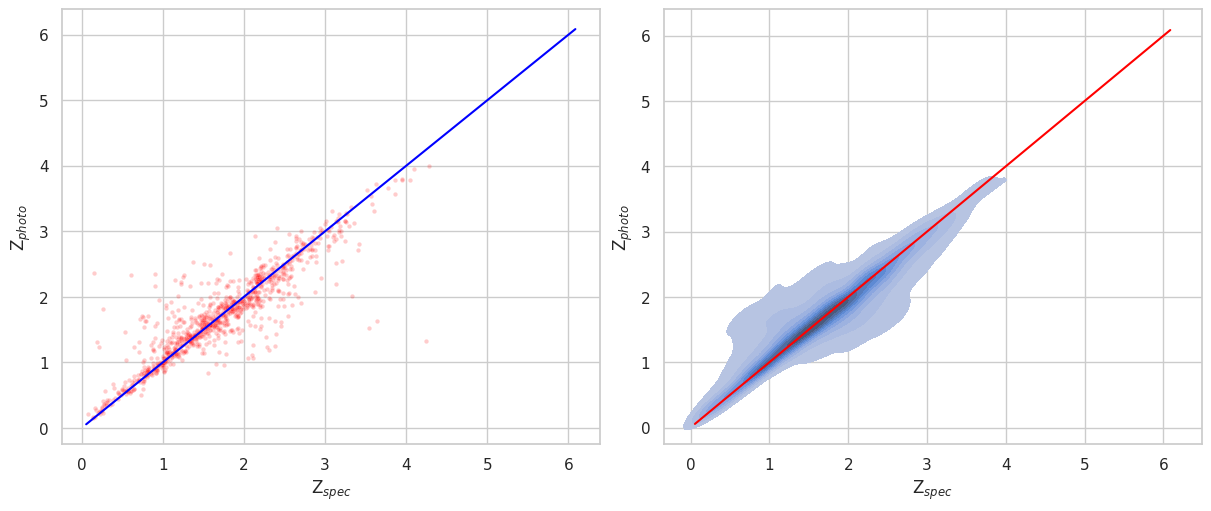

In [9]:
y_pred = model.predict(X_test).reshape(-1)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mean_redshift_err, redshift_err_std = redshift_error(y_test, y_pred)
print(f"MSE: {mse:.2f}")
print(f"R^2: {r2*100:.0f}%")
print(f"Redshift error: {mean_redshift_err:.2f} +/- {redshift_err_std:.2f}")
true_vs_pred_plot(y_test, y_pred)

MSE: 0.03
R^2: 84%
Redshift error: 0.01 +/- 0.11


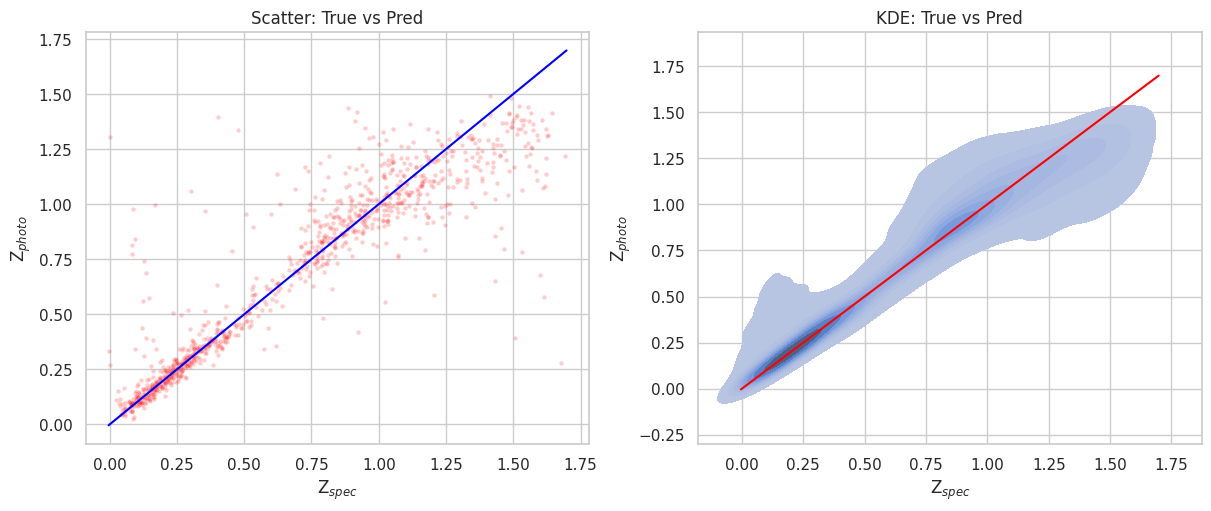

In [35]:
# basic regressor for galaxies
df_galaxy = df[df["SPECTYPE"] == galaxy]
X = df_galaxy[magnitudes + colors]
y = df_galaxy["Z"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

model_galaxy = XGBRegressor(n_jobs=16)
model_galaxy.fit(X_train,y_train)
y_pred = model_galaxy.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mean_redshift_err, redshift_err_std = redshift_error(y_test, y_pred)
print(f"MSE: {mse:.2f}")
print(f"R^2: {r2*100:.0f}%")
print(f"Redshift error: {mean_redshift_err:.2f} +/- {redshift_err_std:.2f}")
plot_true_vs_pred(y_test, y_pred)

In [50]:
df_both = df_default[df_default['SPECTYPE'].isin([galaxy, quasar])]
df_both[magnitudes].isin([-99.0,99.0]).sum()

MAG_GAAP_u     151129
MAG_GAAP_g       8270
MAG_GAAP_r       1797
MAG_GAAP_i1     12662
MAG_GAAP_i2     12524
MAG_GAAP_Z      88858
MAG_GAAP_Y      95987
MAG_GAAP_J      88711
MAG_GAAP_H     124364
MAG_GAAP_Ks    124368
dtype: int64

In [47]:
df_qso = df_default[df_default['SPECTYPE'].isin([ quasar])]
df_qso[magnitudes].isin([-99.0,99.0]).sum()

MAG_GAAP_u     4384
MAG_GAAP_g      139
MAG_GAAP_r      187
MAG_GAAP_i1     435
MAG_GAAP_i2     595
MAG_GAAP_Z     7147
MAG_GAAP_Y     7446
MAG_GAAP_J     7047
MAG_GAAP_H     7956
MAG_GAAP_Ks    7750
dtype: int64

In [48]:
df_gal = df_default[df_default['SPECTYPE'].isin([galaxy])]
df_gal[magnitudes].isin([-99.0,99.0]).sum()

MAG_GAAP_u     146745
MAG_GAAP_g       8131
MAG_GAAP_r       1610
MAG_GAAP_i1     12227
MAG_GAAP_i2     11929
MAG_GAAP_Z      81711
MAG_GAAP_Y      88541
MAG_GAAP_J      81664
MAG_GAAP_H     116408
MAG_GAAP_Ks    116618
dtype: int64

In [6]:
%load_ext tensorboard